In [25]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [26]:
import csv
# loading and preprocessing
def load_data(name):
    data = []
    # read in csv, split the information and save into df
    with open(name, 'r') as file:
        reader = csv.reader(file, delimiter = ';')
        for row in reader:
            data.append(row)
    df = pd.DataFrame(data[1:-1])
    # set names and dtypes in df
    df.columns=['produced_time','predicted_time','wind speed','power']
    df["wind speed"] = pd.to_numeric(df["wind speed"])
    df["power"] = pd.to_numeric(df["power"])
    df["produced_time"] = pd.to_datetime(df["produced_time"]) 
    df["predicted_time"] = pd.to_datetime(df["predicted_time"]) 
    return df

# As far as I understood the measurements are for training/building the model -> df_train, 
# and the forecasts are for testing the model -> df_test.
df_train = load_data('measurement.csv')
df_test = load_data('forecast.csv')
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   produced_time   1230 non-null   datetime64[ns]
 1   predicted_time  1230 non-null   datetime64[ns]
 2   wind speed      1230 non-null   float64       
 3   power           1230 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 38.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   produced_time   270 non-null    datetime64[ns]
 1   predicted_time  270 non-null    datetime64[ns]
 2   wind speed      270 non-null    float64       
 3   power           270 non-null    float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 8.6 KB
None


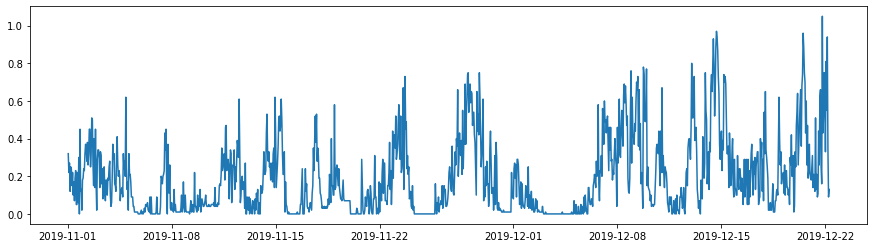

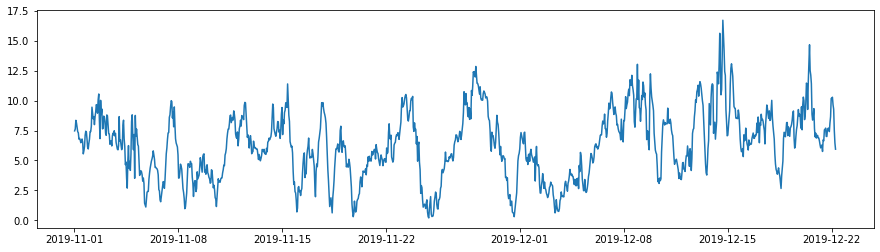

In [27]:
# I know the task only cares only about the wind speed to power relation, 
# but for clarity and overview I want to plot the time series.
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(4)
plt.plot(df_train['predicted_time'],df_train['power'])
plt.show()
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(4)
plt.plot(df_train['predicted_time'],df_train['wind speed'])
plt.show()

In [28]:
# Now to the real task, the relation between wind speed -> x, and power -> y. 
# As I am not planning to train a neural network or other complex model with many epochs I'm fine with only a train and test. set
X_train = df_train['wind speed'].to_numpy()
X_train = np.reshape(X_train,(-1,1))
y_train = df_train['power'].to_numpy()

X_test = df_test['wind speed'].to_numpy()
X_test = np.reshape(X_test,(-1,1))
y_test = df_test['power'].to_numpy()

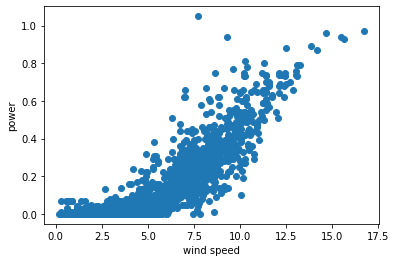

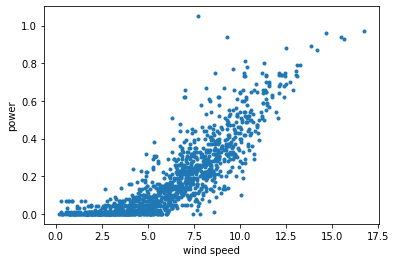

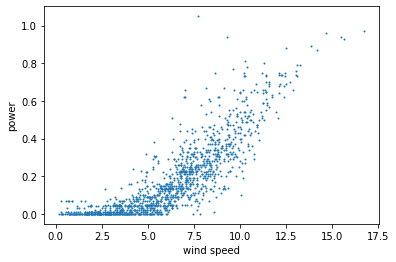

In [29]:
# To get an intuition I plot some variations of the data
parametrizations = []
plt.plot(df_train['wind speed'],df_train['power'],linestyle='', marker='o')
plt.xlabel('wind speed')
plt.ylabel('power')
plt.show()
plt.plot(df_train['wind speed'],df_train['power'],linestyle='', marker='o', markersize=3)
plt.xlabel('wind speed')
plt.ylabel('power')
plt.show()
plt.plot(df_train['wind speed'],df_train['power'],linestyle='', marker='o', markersize=1)
plt.xlabel('wind speed')
plt.ylabel('power')
plt.show()

In [30]:
# Seems like the slope is small in the beginning and rises around a wind speed of 5-7.5. 
# But then it's looking like quite a constant slope aswell, like 2 seperate linear regressions.
# Because an only linear map doesn't seem to do the job, so a basic linear regression or similar isnt't useful.
# Because the we have only one feature a decision tree isn't useful aswell.
# Because of the simplicity of the data a polynomial regression is probably going to do the job.
# Because of the simplicity I dont think we need any regularizating linear models like Lasso or Ridge Regression
# Because we only predict values between 0 and 1 it shouldnt make big difference if we use normal Linear Regression or Huber,
# because we don't get the benefit of the change of the loss function. To keep simplicity I will keep the Linear Regression.
# But for interpretability I will use the mean absolute loss to compare the models. We are only squaring values below 1, 
# so I think it does make a big difference in the error calculation but the absolute error is easier to interpret
# If this doesn't work well we still could try a neural net, 
# but it would probably overfit on data with just one feature and not that complex behaviour.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

# I will try different, but low degrees, to see what works best
polies = []
models = []
degrees = []
train_errors = []
test_errors = []

for d in range(1,7):
    # transform the data to polynomial
    poly = PolynomialFeatures(degree=d)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.fit_transform(X_test)
    
    # fit linear regression
    reg = LinearRegression(fit_intercept = True)  
    reg.fit(X_poly_train, y_train)
    models.append(reg)
    polies.append(poly)
    
    # calculate train and test error
    train_error = mean_absolute_error(y_train,reg.predict(X_poly_train))
    test_error = mean_absolute_error(y_test,reg.predict(X_poly_test))
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    degrees.append(d)
    
    print('Mean absolute train error for',d,'degrees:',train_error)
    print('Mean absolute test error for',d,'degrees:',test_error)

Mean absolute train error for 1 degrees: 0.08313092742431545
Mean absolute test error for 1 degrees: 0.07961055233784833
Mean absolute train error for 2 degrees: 0.06346356233988334
Mean absolute test error for 2 degrees: 0.06422310676654977
Mean absolute train error for 3 degrees: 0.06227918760698643
Mean absolute test error for 3 degrees: 0.06149169249409607
Mean absolute train error for 4 degrees: 0.06196867739913309
Mean absolute test error for 4 degrees: 0.06176060070705231
Mean absolute train error for 5 degrees: 0.061957389328605186
Mean absolute test error for 5 degrees: 0.06183166067790852
Mean absolute train error for 6 degrees: 0.061966841103900334
Mean absolute test error for 6 degrees: 0.0615014138594354


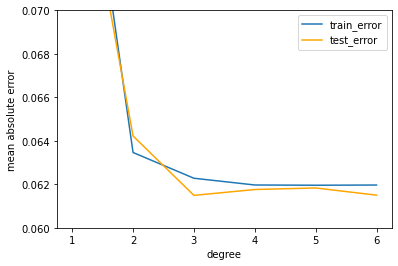

In [32]:
plt.plot(degrees,train_errors,label='train_error')
plt.plot(degrees,test_errors,color='orange',label='test_error')
plt.ylim(0.06,0.07)
plt.xlabel('degree')
plt.ylabel('mean absolute error')
plt.legend()
plt.show()

In [33]:
# The test error gets worse when taking more than 3 degrees, so we should not go beyond that,
# but the difference between 2 or 3 degrees is already only aroung 0.0025 which we can interpret in this case as about 0.25%.
# To get an better intuition I plot both

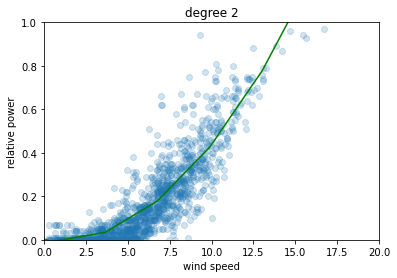

(0.0, 20.0)

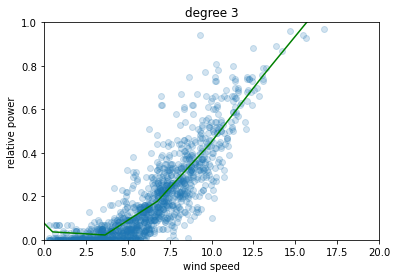

In [34]:
x_grid = np.linspace(-250, 60, num = 100).reshape(-1, 1)
poly = polies[1]
poly_reg = models[1]
x_grid_poly = poly.transform(x_grid)
y_pred_poly = poly_reg.predict(x_grid_poly)
plt.scatter(X_train, y_train,alpha=0.2) 
plt.plot(x_grid, y_pred_poly, color='green', label='degree 2')
plt.xlabel('wind speed')
plt.ylabel('relative power')
plt.title('degree 2')
plt.ylim(0,1)
plt.xlim(0,20)
plt.show()
poly = polies[2]
poly_reg = models[2]
x_grid_poly = poly.transform(x_grid)
y_pred_poly = poly_reg.predict(x_grid_poly)
plt.scatter(X_train, y_train,alpha=0.2) 
plt.plot(x_grid, y_pred_poly, color='green', label='degree 2')
plt.xlabel('wind speed')
plt.ylabel('relative power')
plt.title('degree 3')
plt.ylim(0,1)
plt.xlim(0,20)

In [35]:
# When it goes to the max degree seems to adapt a little better, but what concerns me is the beginning of it.
# Degree 3 predicts decreasing positive values in the beginning, which makes, as far as I understand, no sense

In [41]:
made_up_x = [[0],[0.1],[0.2],[0.3],[0.4],[0.5],[0.6],[0.7]]
made_x_poly = polies[3].fit_transform(made_up_x)
models[3].predict(made_x_poly)

array([0.02834227, 0.02635749, 0.02445729, 0.02264454, 0.02092204,
       0.01929251, 0.01775863, 0.016323  ])

In [37]:
# In conclusion I prefer the degree 2 polynomial, because of the better fit in the beginnning and only minimal more error,
# but it depends on the use case. When we care a lot more about the predictions on a lot of wind we could also use degree 3
# Because of the variance of the data I don't think a neural net can do any better here, 
# at least not without massive overfitting. 
# Because of this I will stop here with a quite simple model, which does not concern me because 
# it's quite a simple task aswell and I think overcomplicating it doesn't bring any value.